# HW2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

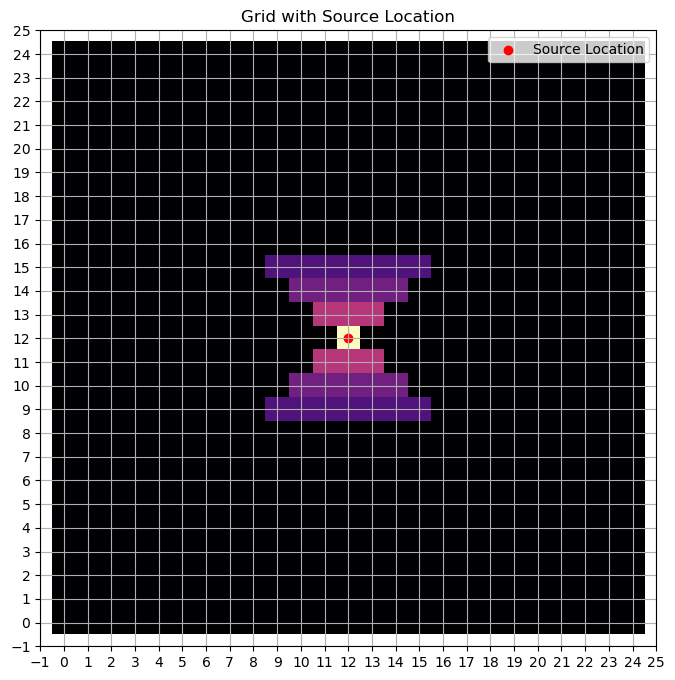

In [3]:
def location_function(sampled_locations, source_location):
    """
    Sample locations relative to the source, and return an array of probabilities of reading a signal.

    Args:
        sampled_locations (np.array of shape (n, 2)): x, y coordinates of the sampled locations.
        source_location (np.array of shape (2,)): x, y coordinates of the source location.
    Returns:
        np.array: Array of probabilities of reading a signal at each sampled location.
    """
    # Compute the absolute differences between each sampled location and the source location.
    dx = np.abs(sampled_locations[:, 0] - source_location[0])
    dy = np.abs(sampled_locations[:, 1] - source_location[1])
    
    # Initialize an array of zeros for probabilities.
    probabilities = np.zeros(len(dx), dtype=float)

    # Apply conditions using boolean indexing
    mask = (dy == 3) & (dx < 4)
    probabilities[mask] = 1/4

    mask = (dy == 2) & (dx < 3)
    probabilities[mask] = 1/3

    mask = (dy == 1) & (dx < 2)
    probabilities[mask] = 1/2

    mask = (dy == 0) & (dx < 1)
    probabilities[mask] = 1

    return probabilities


def sample_by_location(samples, source_location):
    """
    Sample a location and return a boolean array indicating whether a signal is read.

    Args:
        samples (np.array of shape (n, 2)): x, y coordinates of the sampled locations.
        source_location (np.array of shape (2,)): x, y coordinates of the source location.
    Returns:
        np.array: Boolean array with True if a signal is detected at the corresponding location.
    """
    # Get the probability of reading a signal for each sample
    f = location_function(samples, source_location)
    random_number = np.random.rand(len(samples))
    return random_number < f


# Setup the 25x25 grid
grid_size = 25
x = np.arange(grid_size)
y = np.arange(grid_size)
X, Y = np.meshgrid(x, y)

# Flatten the grid to obtain a list of (x, y) coordinate pairs.
locations = np.column_stack((X.ravel(), Y.ravel()))

# Define the source location
source_location = np.array([12, 12])

# Visualize the grid based on the probability intensity derived from location_function
Z = location_function(locations, source_location)
Z = Z.reshape(X.shape)

plt.figure(figsize=(8, 8))
plt.imshow(Z, extent=(-0.5, grid_size - 0.5, -0.5, grid_size - 0.5), origin='lower', cmap='magma')
plt.scatter(source_location[0], source_location[1], marker='o', color='red', label='Source Location')

plt.xlim(-1, grid_size)
plt.ylim(-1, grid_size)
plt.xticks(np.arange(-1, grid_size + 1, 1))
plt.yticks(np.arange(-1, grid_size + 1, 1))
plt.grid()
plt.title('Grid with Source Location')
plt.legend()
plt.show()

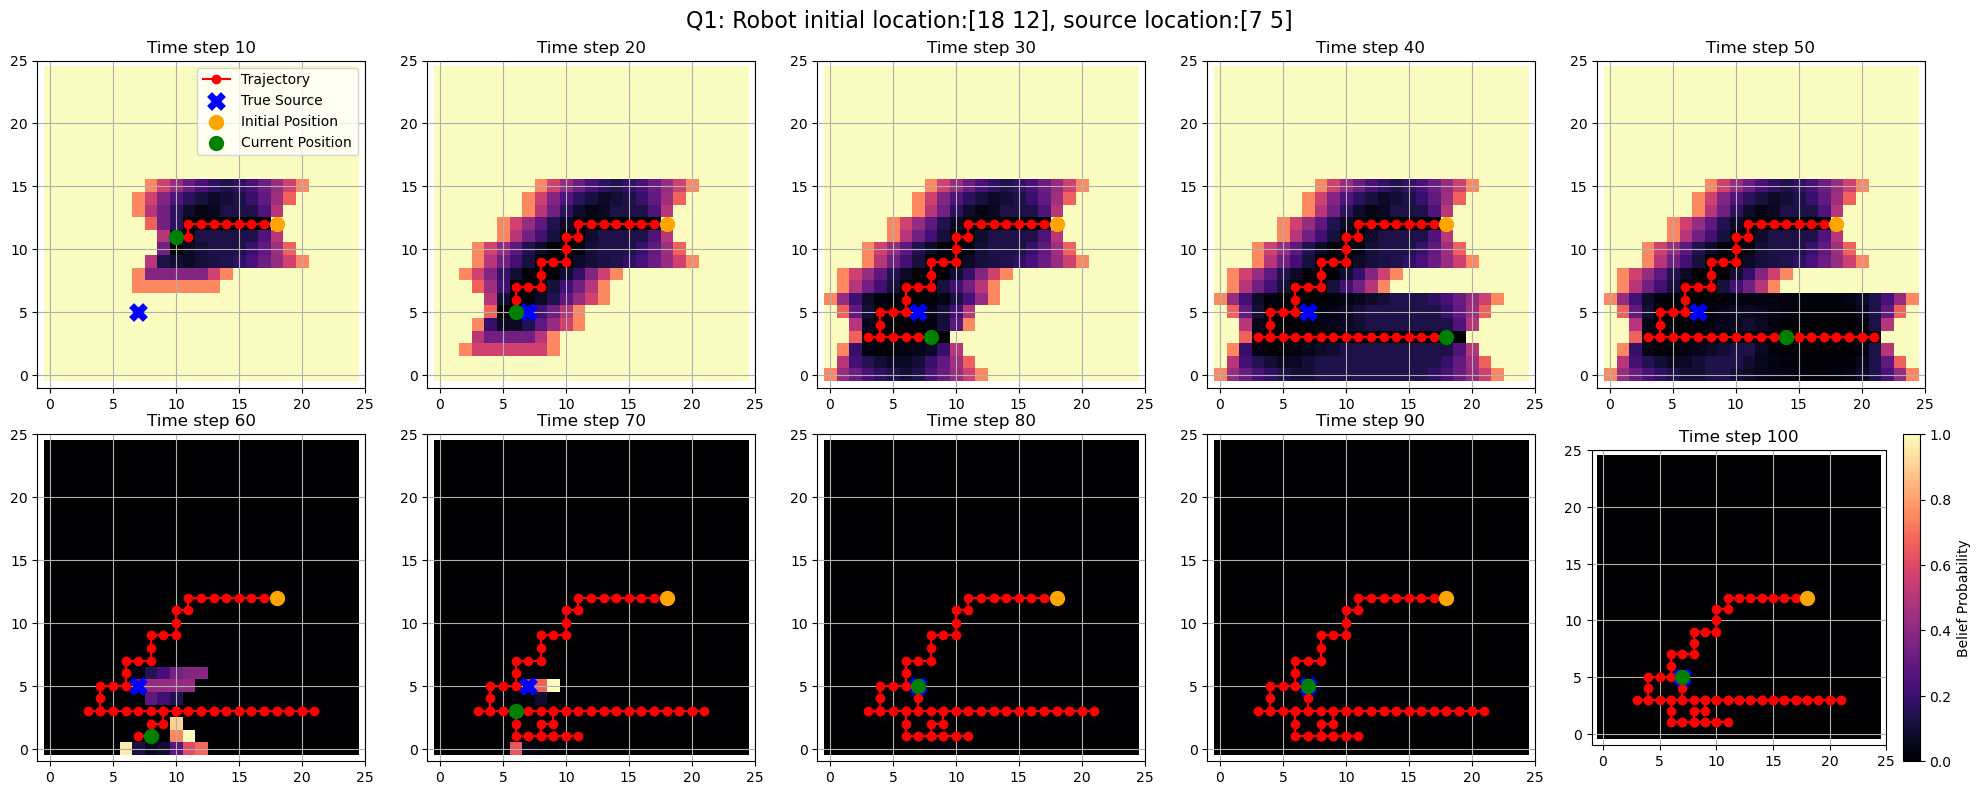

In [ ]:
# -------------------- Simulation Setup -------------------- #
# Set random seed for reproducibility
np.random.seed(25)

grid_size = 25
x_coords = np.arange(grid_size)
y_coords = np.arange(grid_size)
# Build grid points (candidate source locations)
grid_points = np.array([(x, y) for y in y_coords for x in x_coords])  # shape (625, 2)

# Initialize a uniform prior belief over source locations
prior = np.ones(len(grid_points)) / len(grid_points)

# Randomly choose a true source location from the grid
true_source_index = np.random.randint(len(grid_points))
true_source = grid_points[true_source_index]

# Randomly choose an initial robot location from the grid
robot_index = np.random.randint(len(grid_points))
robot_location = grid_points[robot_index].copy()

# Logging for trajectory and belief history
robot_trajectory = [robot_location.copy()]
measurements = []
belief_history = []

num_steps = 100  # Total time steps

# -------------------- Exploration & Bayesian Update Loop -------------------- #
for step in range(num_steps):
    # ---- Exploration Strategy: Choose Action ---- #
    # Pick candidate source with maximum current belief.
    best_candidate_index = np.argmax(prior)
    best_candidate = grid_points[best_candidate_index]
    delta = best_candidate - robot_location  # direction vector
    
    if np.all(delta == 0):
        move = np.array([0, 0])
    else:
        # Move in the direction with the larger difference.
        if abs(delta[0]) > abs(delta[1]):
            move = np.array([np.sign(delta[0]), 0])
        elif abs(delta[1]) > abs(delta[0]):
            move = np.array([0, np.sign(delta[1])])
        else:
            # If equal, choose randomly between x and y directions.
            if np.random.rand() < 0.5:
                move = np.array([np.sign(delta[0]), 0])
            else:
                move = np.array([0, np.sign(delta[1])])
    
    # Update robot location; enforce grid boundaries.
    new_location = robot_location + move
    new_location[0] = np.clip(new_location[0], 0, grid_size - 1)
    new_location[1] = np.clip(new_location[1], 0, grid_size - 1)
    robot_location = new_location.copy()
    robot_trajectory.append(robot_location.copy())
    
    # ---- Measurement Simulation ---- #
    measurement = sample_by_location(np.array([robot_location]), true_source)[0]
    measurements.append(measurement)
    
    # ---- Bayesian Update ---- #
    # Compute the likelihood that the sensor reading (measurement) would occur,
    # if the source was at any candidate grid point.
    probs = location_function(grid_points, robot_location)
    likelihood = probs if measurement else (1 - probs)
    
    # Update the belief: new posterior ∝ likelihood × prior, and normalize.
    prior = likelihood * prior
    total = np.sum(prior)
    if total > 0:
        prior = prior / total
    else:
        prior = np.ones(len(grid_points)) / len(grid_points)
    
    belief_history.append(prior.copy())

# -------------------- Visualization of Belief & Trajectory -------------------- #

# Create a 2x5 grid plot for time steps 10, 20, ..., 100.
time_steps_to_plot = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
axs = axs.flatten()

for i, t in enumerate(time_steps_to_plot):
    ax = axs[i]
    # Get belief for the specified time step.
    # belief_history index is 0-based, so t=10 corresponds to belief_history[9]
    belief = belief_history[t - 1]
    belief_grid = belief.reshape((grid_size, grid_size))
    # Show the belief grid as a heatmap.
    im = ax.imshow(belief_grid, origin='lower', cmap='magma',
                   extent=[-0.5, grid_size - 0.5, -0.5, grid_size - 0.5])
    # Plot the robot trajectory up to this time step.
    traj = np.array(robot_trajectory[:t])
    ax.plot(traj[:, 0], traj[:, 1], marker='o', color='red', label='Trajectory')
    # Mark the true source location
    ax.scatter(true_source[0], true_source[1], marker='x', color='blue', s=100, label='True Source', linewidths=5, zorder=3)
    # Mark the initial position
    ax.scatter(robot_trajectory[0][0], robot_trajectory[0][1], marker='o', color='orange', s=100, label='Initial Position',zorder=3)
    # Mark the current position
    ax.scatter(robot_trajectory[t - 1][0], robot_trajectory[t - 1][1], marker='o', color='green', s=100, label='Current Position',zorder=3)
    # Set titles and labels
    ax.set_title(f"Time step {t}, robot pos: {robot_trajectory[t - 1]}")
    ax.set_xlim(-1, grid_size)
    ax.set_ylim(-1, grid_size)
    ax.grid(True)
    # Optional: add legend only to the first subplot for clarity.
    if i == 0:
        ax.legend(loc='upper right')
    
    # Add a colorbar to the last subplot
    if i == len(time_steps_to_plot) - 1:
        # Create a colorbar for the last subplot
        cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.08, pad=0.05)
        cbar.set_label('Belief Probability')
        cbar.ax.tick_params(labelsize=10)

# add a title:
plt.suptitle(f'Q1: Robot initial location:{robot_trajectory[0]}, source location:{true_source}', fontsize=16)
# Show the plot

plt.tight_layout()
plt.show()
